# Graph-UNets

Hereafter is a modification of the implementation of the paper. Only the encoder is considered here, we can think of it as a graph CNN.

## Imports

In [1]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch import nn
from torch_geometric.nn import GCNConv,TopKPooling,global_mean_pool
from torch_geometric import seed_everything
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from torch_geometric.utils.sparse import dense_to_sparse,to_torch_coo_tensor
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## Dataset

For our experiment we picked the PROTEINS dataset, which is one of those selected in the Graph-UNets paper.  
The dataset was divided as such:
- 81% for the training set
- 9% for the validation set
- 10 % for the test set

In [2]:
seed_everything(77) #Seed for all random actions, this library is a proxy for other libraries, e.g. pytorch
path=""
dataset = TUDataset(path, name='PROTEINS').shuffle() #Here we shuffle the dataset to break any potential order correlation

print("Dataset is undirected? ", dataset[0].is_undirected()) #This is a vital information!
print ("Len of dataset: ", len(dataset))
train_set = dataset[:int(0.9*len(dataset))]
train_dataset = train_set[:int(0.9*len(train_set))]
val_dataset = train_set[int(0.9*len(train_set)):]
test_dataset = dataset[int(0.9*len(dataset)):]
print("Len of train dataset: ", len(train_dataset))
print("Len of validation dataset: ",len(val_dataset))
print("Len of test dataset: ",len(test_dataset))

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Dataset is undirected?  True
Len of dataset:  1113
Len of train dataset:  900
Len of validation dataset:  101
Len of test dataset:  112


## Graph Pooling

![title](graphpool.png)

In [6]:
class gPool(nn.Module):
    """
    Our implementation of the pooling methodology described in the paper, above you can see the pseudocode
    """
    def __init__(self,in_dim,ratio):
        super().__init__()
        self.in_dim=in_dim
        self.ratio=ratio
        self.p=nn.Linear(in_dim,1)
        self.sigmoid=nn.Sigmoid()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,edge_index,batch):
        
        #y is described as a learnable projection, hence we estimated a linear layer to be a suitable choice
        
        y=self.p(xl) #/torch.norm(self.p(xl)) #DO WE HAVE TO INSERT THE NORM?
        
        k=int(self.ratio*len(y))#Number of selected nodes, the k in TopkPooling
        
        topks, idx =torch.topk(y,k,dim=0) #The k elements with top scores, and their corresponding idx
        
        y_hat=self.sigmoid(topks)
        xl_hat=xl[idx,:].squeeze() #Feature matrix of topk nodes
        xl1=xl_hat * y_hat  #Gate operation
        
        al = torch.as_tensor(to_scipy_sparse_matrix(edge_index,num_nodes=len(y)).todense(), device = self.device)
        al1 = torch.index_select(torch.as_tensor(al),0,idx.squeeze()) #no direct indexing because of ram overloading
        al1=torch.index_select(al1,1,idx.squeeze())
        sparsel1=dense_to_sparse(al1)
        edge_index_pooled=torch.sparse_coo_tensor(sparsel1[0],sparsel1[1]).coalesce().indices() #Our model elaborates coo tensors
        
        batch = batch[idx.squeeze()]
        
        return xl1, edge_index_pooled, idx.squeeze(), batch

In [4]:
"""
Simple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension
p=nn.Linear(4,1)
xl=torch.ones((6,4))
y=p(xl)/torch.norm(p(xl))
xl2=torch.ones((2,4))
print(torch.norm(p(xl),dim=0))
print(torch.norm(p(xl2),dim=0))
"""

'\nSimple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension\np=nn.Linear(4,1)\nxl=torch.ones((6,4))\ny=p(xl)/torch.norm(p(xl))\nxl2=torch.ones((2,4))\nprint(torch.norm(p(xl),dim=0))\nprint(torch.norm(p(xl2),dim=0))\n'

## U-Net

The U-Net as described in the paper, below is the graphical representation in the paper, however the number of up and down blocks is inferior with respect to the paper description, which is four upblocks and four downblocks as presented in the code below.

![title](unet_structure.png)

In [7]:
class UNet(nn.Module):
    def __init__(self, improved = False, dropout = 0.3 ):
        super().__init__()
        """
        For the original operation we adoperated GCNConv, considered one of the "basic" convolutional layer for graphs
        """
        self.in_conv = GCNConv(dataset.num_features, 16, improved= improved)
        
        self.GC1 = GCNConv(16, 32, dropout= dropout, improved= improved) 
        self.GC2 = GCNConv(32, 64, dropout= dropout, improved= improved)
        self.GC3 = GCNConv(64, 128, dropout= dropout, improved= improved)
        self.GC4 = GCNConv(128, 256,dropout= dropout, improved= improved)
        self.act=nn.ELU()
        
        self.gPool1 = gPool(16, 0.9)
        self.gPool2 = gPool(32, 0.7)
        self.gPool3 = gPool(64, 0.6)
        self.gPool4 = gPool(128, 0.5)
        
        self.out_conv = GCNConv(256, dataset.num_features, improved= improved)
        
        self.linear = nn.Linear(dataset.num_features, 1)
    
    def forward(self,x,edge_index,batch,batch_size):
        x1 = self.in_conv(x, edge_index)
        x1 = self.act(x1)
        
        # Encoder
        
        #Pool1
        x2, edge_index2, idx2, batch= self.gPool1(x1,edge_index,batch)
        x2 = self.act(x2)
        
        x3 = self.GC1(x2, edge_index2)
        x3 = self.act(x3)
        
        #Pool2
        x4,  edge_index4, idx4, batch = self.gPool2(x3,edge_index2, batch)
        x4 = self.act(x4)
        
        x5 = self.GC2(x4, edge_index4)
        x5 = self.act(x5)
        
        #Pool3
        x6,  edge_index6, idx6, batch= self.gPool3(x5,edge_index4, batch)
        x6 = self.act(x6)
        
        x7 = self.GC3(x6, edge_index6)
        x7 = self.act(x7)
        
        #Pool4
        x8,  edge_index8, idx8, batch= self.gPool4(x7,edge_index6, batch)
        x8 = self.act(x8)
        
        x9 = self.GC4(x8, edge_index8)
        x9 = self.act(x9)
        
        x10=self.out_conv(x9, edge_index8)
        x10=self.act(x10)
        
        #Readout
        x10 = global_mean_pool(x10, batch, batch_size) #readout layer commonly adoperated - reference: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l
        x10 = self.act(x10)
        
        #Linear
        x10=self.linear(x10)
        
        return x10

## Parameters customization

In [8]:
seed_everything(77)
lrate =0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=UNet(improved=False, dropout=0.3).to(device) #Customize the model by changing these parameters

optimizer = torch.optim.Adam(model.parameters(), lr=lrate) #Adam because it is adaptive
criterion=nn.BCEWithLogitsLoss()
sigmoid=nn.Sigmoid()
epochs=200

## Training

Here we start the training of the model, we perform one epoch on the training set and one on the validation set.

In [9]:
seed_everything(77)
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc=0.0
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device) #E.g. DataBatch(edge_index=[2, 19062], x=[5024, 3], y=[128], batch=[5024], ptr=[129])
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        loss.backward()
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        train_acc+=acc
        train_loss += loss.item()
        optimizer.step()
        
    epoch_train_loss=train_loss/len(train_loader) #We compute the average train loss for each epoch
    train_losses.append(epoch_train_loss)
    epoch_train_accuracy=train_acc/len(train_loader) #We compute the average train accuracy for each epoch
    train_accuracies.append(epoch_train_accuracy)
    print(f"Training loss epoch {epoch}: ", epoch_train_loss)
    print(f"Training accuracy epoch {epoch}: ", epoch_train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_acc=0.0
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        val_acc+=acc
        val_loss += loss.item()
    
    epoch_val_loss=val_loss/len(val_loader) #We compute the average validation loss for each epoch
    val_losses.append(epoch_val_loss)
    epoch_val_accuracy=val_acc/len(val_loader) #We compute the average validation accuracy for each epoch
    val_accuracies.append(epoch_val_accuracy)
    print(f"Validation loss epoch {epoch}: ", epoch_val_loss)
    print(f"Validation accuracy epoch {epoch}: ", epoch_val_accuracy)
print('Finished Training')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 0:  0.7679956331849098
Training accuracy epoch 0:  0.408203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]


Validation loss epoch 0:  0.7426422834396362
Validation accuracy epoch 0:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.79it/s]


Training loss epoch 1:  0.7138307169079781
Training accuracy epoch 1:  0.3759765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]


Validation loss epoch 1:  0.6847083568572998
Validation accuracy epoch 1:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.09it/s]


Training loss epoch 2:  0.6424573063850403
Training accuracy epoch 2:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Validation loss epoch 2:  0.6569620370864868
Validation accuracy epoch 2:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.43it/s]


Training loss epoch 3:  0.5823242589831352
Training accuracy epoch 3:  0.72265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.16it/s]


Validation loss epoch 3:  0.7362335920333862
Validation accuracy epoch 3:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.80it/s]


Training loss epoch 4:  0.6707520484924316
Training accuracy epoch 4:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 4:  0.7137976288795471
Validation accuracy epoch 4:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.81it/s]


Training loss epoch 5:  0.6062264516949654
Training accuracy epoch 5:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 5:  0.6775832176208496
Validation accuracy epoch 5:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


Training loss epoch 6:  0.6425180062651634
Training accuracy epoch 6:  0.662109375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


Validation loss epoch 6:  0.6681689023971558
Validation accuracy epoch 6:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 7:  0.6405243128538132
Training accuracy epoch 7:  0.66015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


Validation loss epoch 7:  0.6809545159339905
Validation accuracy epoch 7:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 8:  0.6400493234395981
Training accuracy epoch 8:  0.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 8:  0.6889707446098328
Validation accuracy epoch 8:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.03it/s]


Training loss epoch 9:  0.6505476161837578
Training accuracy epoch 9:  0.6484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


Validation loss epoch 9:  0.687694251537323
Validation accuracy epoch 9:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.50it/s]


Training loss epoch 10:  0.6222901046276093
Training accuracy epoch 10:  0.6884765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 10:  0.6846224069595337
Validation accuracy epoch 10:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 11:  0.6106732338666916
Training accuracy epoch 11:  0.6923828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.39it/s]


Validation loss epoch 11:  0.7001073956489563
Validation accuracy epoch 11:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 12:  0.598574161529541
Training accuracy epoch 12:  0.7197265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 12:  0.7093652486801147
Validation accuracy epoch 12:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


Training loss epoch 13:  0.6218519136309624
Training accuracy epoch 13:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.39it/s]


Validation loss epoch 13:  0.6670221090316772
Validation accuracy epoch 13:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 14:  0.612763524055481
Training accuracy epoch 14:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 14:  0.6787928938865662
Validation accuracy epoch 14:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.91it/s]


Training loss epoch 15:  0.6597421243786812
Training accuracy epoch 15:  0.6337890625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


Validation loss epoch 15:  0.7025407552719116
Validation accuracy epoch 15:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 16:  0.6189622804522514
Training accuracy epoch 16:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Validation loss epoch 16:  0.6810022592544556
Validation accuracy epoch 16:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 17:  0.6421828120946884
Training accuracy epoch 17:  0.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 17:  0.6756576299667358
Validation accuracy epoch 17:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 18:  0.6190559417009354
Training accuracy epoch 18:  0.6923828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]


Validation loss epoch 18:  0.6816830635070801
Validation accuracy epoch 18:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.90it/s]


Training loss epoch 19:  0.6176577061414719
Training accuracy epoch 19:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]


Validation loss epoch 19:  0.6970522999763489
Validation accuracy epoch 19:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 20:  0.6432940512895584
Training accuracy epoch 20:  0.6611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


Validation loss epoch 20:  0.6876527070999146
Validation accuracy epoch 20:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.17it/s]


Training loss epoch 21:  0.6399815604090691
Training accuracy epoch 21:  0.662109375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Validation loss epoch 21:  0.6566389203071594
Validation accuracy epoch 21:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.50it/s]


Training loss epoch 22:  0.6037846468389034
Training accuracy epoch 22:  0.7275390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


Validation loss epoch 22:  0.6788713932037354
Validation accuracy epoch 22:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 23:  0.5936626195907593
Training accuracy epoch 23:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


Validation loss epoch 23:  0.6964947581291199
Validation accuracy epoch 23:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 24:  0.6245322450995445
Training accuracy epoch 24:  0.6962890625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]


Validation loss epoch 24:  0.7264953851699829
Validation accuracy epoch 24:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 25:  0.6598249524831772
Training accuracy epoch 25:  0.6357421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 25:  0.6513118743896484
Validation accuracy epoch 25:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 26:  0.6350074261426926
Training accuracy epoch 26:  0.671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 26:  0.6579869985580444
Validation accuracy epoch 26:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 27:  0.6388422548770905
Training accuracy epoch 27:  0.6708984375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


Validation loss epoch 27:  0.6515318751335144
Validation accuracy epoch 27:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 28:  0.6362318769097328
Training accuracy epoch 28:  0.66796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


Validation loss epoch 28:  0.6576981544494629
Validation accuracy epoch 28:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 29:  0.6147274747490883
Training accuracy epoch 29:  0.7001953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Validation loss epoch 29:  0.6679586172103882
Validation accuracy epoch 29:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 30:  0.5960690677165985
Training accuracy epoch 30:  0.7236328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Validation loss epoch 30:  0.6851263642311096
Validation accuracy epoch 30:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Training loss epoch 31:  0.6392591968178749
Training accuracy epoch 31:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]


Validation loss epoch 31:  0.689521849155426
Validation accuracy epoch 31:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 32:  0.6437569335103035
Training accuracy epoch 32:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 32:  0.6901770830154419
Validation accuracy epoch 32:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 33:  0.6151653081178665
Training accuracy epoch 33:  0.697265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.61it/s]


Validation loss epoch 33:  0.6695865988731384
Validation accuracy epoch 33:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.34it/s]


Training loss epoch 34:  0.5929637737572193
Training accuracy epoch 34:  0.7255859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.49it/s]


Validation loss epoch 34:  0.6646130084991455
Validation accuracy epoch 34:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 35:  0.6123034134507179
Training accuracy epoch 35:  0.7060546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


Validation loss epoch 35:  0.6624425649642944
Validation accuracy epoch 35:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.30it/s]


Training loss epoch 36:  0.6196674481034279
Training accuracy epoch 36:  0.697265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Validation loss epoch 36:  0.674411416053772
Validation accuracy epoch 36:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 37:  0.5974406450986862
Training accuracy epoch 37:  0.7294921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


Validation loss epoch 37:  0.6815709471702576
Validation accuracy epoch 37:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 38:  0.5937174186110497
Training accuracy epoch 38:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]


Validation loss epoch 38:  0.6815500259399414
Validation accuracy epoch 38:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 39:  0.5857768654823303
Training accuracy epoch 39:  0.7255859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


Validation loss epoch 39:  0.7224878072738647
Validation accuracy epoch 39:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Training loss epoch 40:  0.6878125220537186
Training accuracy epoch 40:  0.623046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 40:  0.6840670704841614
Validation accuracy epoch 40:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Training loss epoch 41:  0.6140709668397903
Training accuracy epoch 41:  0.7021484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


Validation loss epoch 41:  0.6561777591705322
Validation accuracy epoch 41:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 42:  0.639290101826191
Training accuracy epoch 42:  0.6640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 42:  0.6665085554122925
Validation accuracy epoch 42:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


Training loss epoch 43:  0.616619661450386
Training accuracy epoch 43:  0.69921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.22it/s]


Validation loss epoch 43:  0.6635324954986572
Validation accuracy epoch 43:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 44:  0.5843614675104618
Training accuracy epoch 44:  0.7314453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 44:  0.6582862138748169
Validation accuracy epoch 44:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.18it/s]


Training loss epoch 45:  0.6799123138189316
Training accuracy epoch 45:  0.634765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.16it/s]


Validation loss epoch 45:  0.6652114987373352
Validation accuracy epoch 45:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 46:  0.615268886089325
Training accuracy epoch 46:  0.701171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 46:  0.6614601612091064
Validation accuracy epoch 46:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Training loss epoch 47:  0.6263479664921761
Training accuracy epoch 47:  0.6845703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.42it/s]


Validation loss epoch 47:  0.6590957641601562
Validation accuracy epoch 47:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 48:  0.6196459010243416
Training accuracy epoch 48:  0.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


Validation loss epoch 48:  0.6879749894142151
Validation accuracy epoch 48:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


Training loss epoch 49:  0.6299903616309166
Training accuracy epoch 49:  0.673828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.72it/s]


Validation loss epoch 49:  0.6817915439605713
Validation accuracy epoch 49:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 50:  0.66274693608284
Training accuracy epoch 50:  0.6416015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Validation loss epoch 50:  0.674019992351532
Validation accuracy epoch 50:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Training loss epoch 51:  0.6050581000745296
Training accuracy epoch 51:  0.72265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Validation loss epoch 51:  0.662386417388916
Validation accuracy epoch 51:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.03it/s]


Training loss epoch 52:  0.6428438201546669
Training accuracy epoch 52:  0.6611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 52:  0.6697741150856018
Validation accuracy epoch 52:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 53:  0.5996130779385567
Training accuracy epoch 53:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 53:  0.6781768798828125
Validation accuracy epoch 53:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


Training loss epoch 54:  0.5917879268527031
Training accuracy epoch 54:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Validation loss epoch 54:  0.6827061772346497
Validation accuracy epoch 54:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]


Training loss epoch 55:  0.6502883732318878
Training accuracy epoch 55:  0.6689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


Validation loss epoch 55:  0.6724649667739868
Validation accuracy epoch 55:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 56:  0.632946714758873
Training accuracy epoch 56:  0.673828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.54it/s]


Validation loss epoch 56:  0.6646310687065125
Validation accuracy epoch 56:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 57:  0.6561380252242088
Training accuracy epoch 57:  0.6298828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s]


Validation loss epoch 57:  0.662490963935852
Validation accuracy epoch 57:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Training loss epoch 58:  0.6509035974740982
Training accuracy epoch 58:  0.6357421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


Validation loss epoch 58:  0.6568954586982727
Validation accuracy epoch 58:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Training loss epoch 59:  0.6114748641848564
Training accuracy epoch 59:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]


Validation loss epoch 59:  0.6505319476127625
Validation accuracy epoch 59:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 60:  0.5948487482964993
Training accuracy epoch 60:  0.7294921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]


Validation loss epoch 60:  0.6405945420265198
Validation accuracy epoch 60:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 61:  0.6127474382519722
Training accuracy epoch 61:  0.70703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 61:  0.6605013012886047
Validation accuracy epoch 61:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 62:  0.5932748541235924
Training accuracy epoch 62:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]


Validation loss epoch 62:  0.6465005278587341
Validation accuracy epoch 62:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 63:  0.6664690971374512
Training accuracy epoch 63:  0.640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.57it/s]


Validation loss epoch 63:  0.6514185667037964
Validation accuracy epoch 63:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.04it/s]


Training loss epoch 64:  0.598799467086792
Training accuracy epoch 64:  0.7275390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


Validation loss epoch 64:  0.6269993782043457
Validation accuracy epoch 64:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 65:  0.6328353807330132
Training accuracy epoch 65:  0.669921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


Validation loss epoch 65:  0.6317766904830933
Validation accuracy epoch 65:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 66:  0.5890136212110519
Training accuracy epoch 66:  0.73046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 66:  0.6404027342796326
Validation accuracy epoch 66:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 67:  0.6506001427769661
Training accuracy epoch 67:  0.6689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]


Validation loss epoch 67:  0.6527889370918274
Validation accuracy epoch 67:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 68:  0.609195202589035
Training accuracy epoch 68:  0.701171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]


Validation loss epoch 68:  0.6399009823799133
Validation accuracy epoch 68:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 69:  0.6349292173981667
Training accuracy epoch 69:  0.66796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


Validation loss epoch 69:  0.6529656648635864
Validation accuracy epoch 69:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 70:  0.6161232516169548
Training accuracy epoch 70:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


Validation loss epoch 70:  0.6464846730232239
Validation accuracy epoch 70:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 71:  0.617916464805603
Training accuracy epoch 71:  0.6884765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.30it/s]


Validation loss epoch 71:  0.6473411321640015
Validation accuracy epoch 71:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 72:  0.6108903810381889
Training accuracy epoch 72:  0.69921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Validation loss epoch 72:  0.6503141522407532
Validation accuracy epoch 72:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Training loss epoch 73:  0.6097584217786789
Training accuracy epoch 73:  0.697265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 73:  0.6430259346961975
Validation accuracy epoch 73:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 74:  0.6110029369592667
Training accuracy epoch 74:  0.6962890625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


Validation loss epoch 74:  0.650277316570282
Validation accuracy epoch 74:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 75:  0.6048174947500229
Training accuracy epoch 75:  0.69921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


Validation loss epoch 75:  0.6416703462600708
Validation accuracy epoch 75:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


Training loss epoch 76:  0.6134245097637177
Training accuracy epoch 76:  0.7001953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]


Validation loss epoch 76:  0.6361721158027649
Validation accuracy epoch 76:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]


Training loss epoch 77:  0.5886790379881859
Training accuracy epoch 77:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


Validation loss epoch 77:  0.6330894231796265
Validation accuracy epoch 77:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 78:  0.6231977120041847
Training accuracy epoch 78:  0.677734375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


Validation loss epoch 78:  0.6447858214378357
Validation accuracy epoch 78:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 79:  0.6901393681764603
Training accuracy epoch 79:  0.611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.86it/s]


Validation loss epoch 79:  0.6247534155845642
Validation accuracy epoch 79:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.32it/s]


Training loss epoch 80:  0.6156881153583527
Training accuracy epoch 80:  0.701171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]


Validation loss epoch 80:  0.6454781889915466
Validation accuracy epoch 80:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Training loss epoch 81:  0.6057484000921249
Training accuracy epoch 81:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


Validation loss epoch 81:  0.6616348028182983
Validation accuracy epoch 81:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.81it/s]


Training loss epoch 82:  0.5861281007528305
Training accuracy epoch 82:  0.7265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.21it/s]


Validation loss epoch 82:  0.6596232652664185
Validation accuracy epoch 82:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Training loss epoch 83:  0.6088966652750969
Training accuracy epoch 83:  0.7001953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


Validation loss epoch 83:  0.6636316180229187
Validation accuracy epoch 83:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 84:  0.6100445799529552
Training accuracy epoch 84:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.69it/s]


Validation loss epoch 84:  0.6622934341430664
Validation accuracy epoch 84:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.14it/s]


Training loss epoch 85:  0.6081946082413197
Training accuracy epoch 85:  0.6904296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Validation loss epoch 85:  0.6681714653968811
Validation accuracy epoch 85:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 86:  0.6387577727437019
Training accuracy epoch 86:  0.666015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


Validation loss epoch 86:  0.6570494771003723
Validation accuracy epoch 86:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


Training loss epoch 87:  0.5981990098953247
Training accuracy epoch 87:  0.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Validation loss epoch 87:  0.6455151438713074
Validation accuracy epoch 87:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 88:  0.638160727918148
Training accuracy epoch 88:  0.666015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]


Validation loss epoch 88:  0.6301325559616089
Validation accuracy epoch 88:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.18it/s]


Training loss epoch 89:  0.6021382659673691
Training accuracy epoch 89:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 89:  0.6308764219284058
Validation accuracy epoch 89:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 90:  0.6069412231445312
Training accuracy epoch 90:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.53it/s]


Validation loss epoch 90:  0.6339125633239746
Validation accuracy epoch 90:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 91:  0.599528044462204
Training accuracy epoch 91:  0.701171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 91:  0.6426642537117004
Validation accuracy epoch 91:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


Training loss epoch 92:  0.5780481100082397
Training accuracy epoch 92:  0.736328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Validation loss epoch 92:  0.6525421142578125
Validation accuracy epoch 92:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 93:  0.6547855585813522
Training accuracy epoch 93:  0.6494140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Validation loss epoch 93:  0.6385726928710938
Validation accuracy epoch 93:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.56it/s]


Training loss epoch 94:  0.6052850857377052
Training accuracy epoch 94:  0.703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]


Validation loss epoch 94:  0.6237943172454834
Validation accuracy epoch 94:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


Training loss epoch 95:  0.6281495094299316
Training accuracy epoch 95:  0.67578125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


Validation loss epoch 95:  0.618729293346405
Validation accuracy epoch 95:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


Training loss epoch 96:  0.6085805669426918
Training accuracy epoch 96:  0.70703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


Validation loss epoch 96:  0.6199843287467957
Validation accuracy epoch 96:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 97:  0.6205948367714882
Training accuracy epoch 97:  0.6806640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 97:  0.6181758642196655
Validation accuracy epoch 97:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.82it/s]


Training loss epoch 98:  0.5795782022178173
Training accuracy epoch 98:  0.740234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]


Validation loss epoch 98:  0.6205276846885681
Validation accuracy epoch 98:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.52it/s]


Training loss epoch 99:  0.5997927337884903
Training accuracy epoch 99:  0.716796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 99:  0.6150391101837158
Validation accuracy epoch 99:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.56it/s]


Training loss epoch 100:  0.564891442656517
Training accuracy epoch 100:  0.74609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


Validation loss epoch 100:  0.6144933104515076
Validation accuracy epoch 100:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Training loss epoch 101:  0.6018720716238022
Training accuracy epoch 101:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]


Validation loss epoch 101:  0.6179203391075134
Validation accuracy epoch 101:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


Training loss epoch 102:  0.5948820486664772
Training accuracy epoch 102:  0.712890625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.48it/s]


Validation loss epoch 102:  0.6138026714324951
Validation accuracy epoch 102:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 103:  0.5729605704545975
Training accuracy epoch 103:  0.744140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


Validation loss epoch 103:  0.6133912205696106
Validation accuracy epoch 103:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Training loss epoch 104:  0.6108913645148277
Training accuracy epoch 104:  0.689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


Validation loss epoch 104:  0.6222487092018127
Validation accuracy epoch 104:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.93it/s]


Training loss epoch 105:  0.5998727902770042
Training accuracy epoch 105:  0.7060546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 105:  0.6271488070487976
Validation accuracy epoch 105:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 106:  0.5674450993537903
Training accuracy epoch 106:  0.748046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]


Validation loss epoch 106:  0.6272516250610352
Validation accuracy epoch 106:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 107:  0.6180550009012222
Training accuracy epoch 107:  0.6884765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]


Validation loss epoch 107:  0.6337476372718811
Validation accuracy epoch 107:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


Training loss epoch 108:  0.5801370516419411
Training accuracy epoch 108:  0.7236328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 108:  0.6252915859222412
Validation accuracy epoch 108:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.53it/s]


Training loss epoch 109:  0.5846781209111214
Training accuracy epoch 109:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.75it/s]


Validation loss epoch 109:  0.6205014586448669
Validation accuracy epoch 109:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 110:  0.5874972492456436
Training accuracy epoch 110:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 110:  0.630009114742279
Validation accuracy epoch 110:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Training loss epoch 111:  0.5905308201909065
Training accuracy epoch 111:  0.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 111:  0.6349260807037354
Validation accuracy epoch 111:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


Training loss epoch 112:  0.5945063307881355
Training accuracy epoch 112:  0.7158203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 112:  0.635230302810669
Validation accuracy epoch 112:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 113:  0.626274511218071
Training accuracy epoch 113:  0.6806640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.35it/s]


Validation loss epoch 113:  0.6383783221244812
Validation accuracy epoch 113:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 114:  0.6627575233578682
Training accuracy epoch 114:  0.650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


Validation loss epoch 114:  0.6331179141998291
Validation accuracy epoch 114:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 115:  0.6324375569820404
Training accuracy epoch 115:  0.6455078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 115:  0.6370149850845337
Validation accuracy epoch 115:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]


Training loss epoch 116:  0.6477052941918373
Training accuracy epoch 116:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]


Validation loss epoch 116:  0.643172025680542
Validation accuracy epoch 116:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 117:  0.5884034186601639
Training accuracy epoch 117:  0.728515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


Validation loss epoch 117:  0.6486160755157471
Validation accuracy epoch 117:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.63it/s]


Training loss epoch 118:  0.608280211687088
Training accuracy epoch 118:  0.7001953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


Validation loss epoch 118:  0.679386556148529
Validation accuracy epoch 118:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 119:  0.5834282897412777
Training accuracy epoch 119:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 119:  0.692095160484314
Validation accuracy epoch 119:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 120:  0.5878494717180729
Training accuracy epoch 120:  0.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]


Validation loss epoch 120:  0.655311107635498
Validation accuracy epoch 120:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 121:  0.6217094138264656
Training accuracy epoch 121:  0.6923828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


Validation loss epoch 121:  0.6484239101409912
Validation accuracy epoch 121:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 122:  0.6307325661182404
Training accuracy epoch 122:  0.669921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


Validation loss epoch 122:  0.6268676519393921
Validation accuracy epoch 122:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 123:  0.6089376583695412
Training accuracy epoch 123:  0.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


Validation loss epoch 123:  0.6218903064727783
Validation accuracy epoch 123:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Training loss epoch 124:  0.6328860446810722
Training accuracy epoch 124:  0.66796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Validation loss epoch 124:  0.6241782307624817
Validation accuracy epoch 124:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


Training loss epoch 125:  0.5815605744719505
Training accuracy epoch 125:  0.7294921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


Validation loss epoch 125:  0.6349930763244629
Validation accuracy epoch 125:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.51it/s]


Training loss epoch 126:  0.6205651685595512
Training accuracy epoch 126:  0.69921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Validation loss epoch 126:  0.6481812596321106
Validation accuracy epoch 126:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.18it/s]


Training loss epoch 127:  0.6262103766202927
Training accuracy epoch 127:  0.666015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Validation loss epoch 127:  0.6415632367134094
Validation accuracy epoch 127:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Training loss epoch 128:  0.6352783218026161
Training accuracy epoch 128:  0.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


Validation loss epoch 128:  0.6461997628211975
Validation accuracy epoch 128:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Training loss epoch 129:  0.6255916059017181
Training accuracy epoch 129:  0.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.35it/s]


Validation loss epoch 129:  0.6484259963035583
Validation accuracy epoch 129:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


Training loss epoch 130:  0.5761483311653137
Training accuracy epoch 130:  0.7265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.52it/s]


Validation loss epoch 130:  0.6636872291564941
Validation accuracy epoch 130:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 131:  0.6628115996718407
Training accuracy epoch 131:  0.6396484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


Validation loss epoch 131:  0.6418465971946716
Validation accuracy epoch 131:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 132:  0.5584951005876064
Training accuracy epoch 132:  0.744140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


Validation loss epoch 132:  0.6399756073951721
Validation accuracy epoch 132:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 133:  0.5949066504836082
Training accuracy epoch 133:  0.703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.08it/s]


Validation loss epoch 133:  0.6504430174827576
Validation accuracy epoch 133:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


Training loss epoch 134:  0.6036337465047836
Training accuracy epoch 134:  0.6865234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Validation loss epoch 134:  0.6245828866958618
Validation accuracy epoch 134:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


Training loss epoch 135:  0.5427187457680702
Training accuracy epoch 135:  0.755859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 135:  0.6238939762115479
Validation accuracy epoch 135:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 136:  0.5659267269074917
Training accuracy epoch 136:  0.728515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


Validation loss epoch 136:  0.6384405493736267
Validation accuracy epoch 136:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


Training loss epoch 137:  0.5766069367527962
Training accuracy epoch 137:  0.7353515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 137:  0.6311265230178833
Validation accuracy epoch 137:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 138:  0.5701979845762253
Training accuracy epoch 138:  0.7314453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.11it/s]


Validation loss epoch 138:  0.6329896450042725
Validation accuracy epoch 138:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.65it/s]


Training loss epoch 139:  0.5774969160556793
Training accuracy epoch 139:  0.7275390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 139:  0.6376001834869385
Validation accuracy epoch 139:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Training loss epoch 140:  0.5614515393972397
Training accuracy epoch 140:  0.7333984375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.24it/s]


Validation loss epoch 140:  0.6359359622001648
Validation accuracy epoch 140:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 141:  0.6126144602894783
Training accuracy epoch 141:  0.69921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s]


Validation loss epoch 141:  0.6442283391952515
Validation accuracy epoch 141:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 142:  0.6221177875995636
Training accuracy epoch 142:  0.7021484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]


Validation loss epoch 142:  0.6334091424942017
Validation accuracy epoch 142:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


Training loss epoch 143:  0.6067431643605232
Training accuracy epoch 143:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.24it/s]


Validation loss epoch 143:  0.6375463604927063
Validation accuracy epoch 143:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.31it/s]


Training loss epoch 144:  0.6401180475950241
Training accuracy epoch 144:  0.6796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.22it/s]


Validation loss epoch 144:  0.6437079310417175
Validation accuracy epoch 144:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 145:  0.5977115072309971
Training accuracy epoch 145:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.23it/s]


Validation loss epoch 145:  0.6415477395057678
Validation accuracy epoch 145:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Training loss epoch 146:  0.630890928208828
Training accuracy epoch 146:  0.6611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]


Validation loss epoch 146:  0.6455997824668884
Validation accuracy epoch 146:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.93it/s]


Training loss epoch 147:  0.6339587494730949
Training accuracy epoch 147:  0.671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.49it/s]


Validation loss epoch 147:  0.6417332291603088
Validation accuracy epoch 147:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Training loss epoch 148:  0.6689747050404549
Training accuracy epoch 148:  0.6025390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.52it/s]


Validation loss epoch 148:  0.6362461447715759
Validation accuracy epoch 148:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.29it/s]


Training loss epoch 149:  0.5871238484978676
Training accuracy epoch 149:  0.7275390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


Validation loss epoch 149:  0.6348555088043213
Validation accuracy epoch 149:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


Training loss epoch 150:  0.6245549097657204
Training accuracy epoch 150:  0.6884765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


Validation loss epoch 150:  0.6349490284919739
Validation accuracy epoch 150:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 151:  0.5786868557333946
Training accuracy epoch 151:  0.73046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


Validation loss epoch 151:  0.6134064197540283
Validation accuracy epoch 151:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 152:  0.654433511197567
Training accuracy epoch 152:  0.6650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Validation loss epoch 152:  0.60690838098526
Validation accuracy epoch 152:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Training loss epoch 153:  0.6621923893690109
Training accuracy epoch 153:  0.6171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


Validation loss epoch 153:  0.6196054220199585
Validation accuracy epoch 153:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


Training loss epoch 154:  0.6534317135810852
Training accuracy epoch 154:  0.6455078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Validation loss epoch 154:  0.6297006011009216
Validation accuracy epoch 154:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 155:  0.624955378472805
Training accuracy epoch 155:  0.6845703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 155:  0.6307805180549622
Validation accuracy epoch 155:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


Training loss epoch 156:  0.6634831354022026
Training accuracy epoch 156:  0.62109375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Validation loss epoch 156:  0.6283334493637085
Validation accuracy epoch 156:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.60it/s]


Training loss epoch 157:  0.5863784998655319
Training accuracy epoch 157:  0.7353515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.81it/s]


Validation loss epoch 157:  0.6343230605125427
Validation accuracy epoch 157:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 158:  0.6429516896605492
Training accuracy epoch 158:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 158:  0.619881272315979
Validation accuracy epoch 158:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.73it/s]


Training loss epoch 159:  0.6171350404620171
Training accuracy epoch 159:  0.6865234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Validation loss epoch 159:  0.6197720766067505
Validation accuracy epoch 159:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 160:  0.6141550838947296
Training accuracy epoch 160:  0.689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.14it/s]


Validation loss epoch 160:  0.6198055148124695
Validation accuracy epoch 160:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


Training loss epoch 161:  0.6669133454561234
Training accuracy epoch 161:  0.6279296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


Validation loss epoch 161:  0.6196534633636475
Validation accuracy epoch 161:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.39it/s]


Training loss epoch 162:  0.594841718673706
Training accuracy epoch 162:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]


Validation loss epoch 162:  0.6283019781112671
Validation accuracy epoch 162:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.30it/s]


Training loss epoch 163:  0.6065106838941574
Training accuracy epoch 163:  0.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.76it/s]


Validation loss epoch 163:  0.6195363402366638
Validation accuracy epoch 163:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.30it/s]


Training loss epoch 164:  0.5756800472736359
Training accuracy epoch 164:  0.7197265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


Validation loss epoch 164:  0.6276849508285522
Validation accuracy epoch 164:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 165:  0.6278897523880005
Training accuracy epoch 165:  0.6611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.91it/s]


Validation loss epoch 165:  0.6144260764122009
Validation accuracy epoch 165:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 166:  0.6501937359571457
Training accuracy epoch 166:  0.6005859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


Validation loss epoch 166:  0.6366438269615173
Validation accuracy epoch 166:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.52it/s]


Training loss epoch 167:  0.585241511464119
Training accuracy epoch 167:  0.7158203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


Validation loss epoch 167:  0.6402477622032166
Validation accuracy epoch 167:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.41it/s]


Training loss epoch 168:  0.6314046904444695
Training accuracy epoch 168:  0.6650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 168:  0.6499130129814148
Validation accuracy epoch 168:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


Training loss epoch 169:  0.6008479818701744
Training accuracy epoch 169:  0.6962890625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 169:  0.6623154878616333
Validation accuracy epoch 169:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


Training loss epoch 170:  0.5725672468543053
Training accuracy epoch 170:  0.7197265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Validation loss epoch 170:  0.6621057391166687
Validation accuracy epoch 170:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.62it/s]


Training loss epoch 171:  0.5791553258895874
Training accuracy epoch 171:  0.7158203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.31it/s]


Validation loss epoch 171:  0.6603981256484985
Validation accuracy epoch 171:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Training loss epoch 172:  0.6349999308586121
Training accuracy epoch 172:  0.6572265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Validation loss epoch 172:  0.6403105854988098
Validation accuracy epoch 172:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 173:  0.618820808827877
Training accuracy epoch 173:  0.6884765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.35it/s]


Validation loss epoch 173:  0.6377391219139099
Validation accuracy epoch 173:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 174:  0.5997547991573811
Training accuracy epoch 174:  0.7080078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Validation loss epoch 174:  0.6464942097663879
Validation accuracy epoch 174:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 175:  0.5772405043244362
Training accuracy epoch 175:  0.7275390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Validation loss epoch 175:  0.6365348696708679
Validation accuracy epoch 175:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 176:  0.6506214514374733
Training accuracy epoch 176:  0.66015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


Validation loss epoch 176:  0.6491506695747375
Validation accuracy epoch 176:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Training loss epoch 177:  0.6070443913340569
Training accuracy epoch 177:  0.6787109375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 177:  0.6497215032577515
Validation accuracy epoch 177:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 178:  0.6536892578005791
Training accuracy epoch 178:  0.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.14it/s]


Validation loss epoch 178:  0.6445286870002747
Validation accuracy epoch 178:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Training loss epoch 179:  0.635869488120079
Training accuracy epoch 179:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


Validation loss epoch 179:  0.6502426862716675
Validation accuracy epoch 179:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.40it/s]


Training loss epoch 180:  0.6447159498929977
Training accuracy epoch 180:  0.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Validation loss epoch 180:  0.6583593487739563
Validation accuracy epoch 180:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 181:  0.587846927344799
Training accuracy epoch 181:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


Validation loss epoch 181:  0.6160246729850769
Validation accuracy epoch 181:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Training loss epoch 182:  0.6109992787241936
Training accuracy epoch 182:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]


Validation loss epoch 182:  0.6198828816413879
Validation accuracy epoch 182:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


Training loss epoch 183:  0.5759013146162033
Training accuracy epoch 183:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Validation loss epoch 183:  0.6272767782211304
Validation accuracy epoch 183:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Training loss epoch 184:  0.6170838549733162
Training accuracy epoch 184:  0.701171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Validation loss epoch 184:  0.6220455765724182
Validation accuracy epoch 184:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.54it/s]


Training loss epoch 185:  0.5668955966830254
Training accuracy epoch 185:  0.7333984375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 185:  0.6211636662483215
Validation accuracy epoch 185:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 186:  0.5839830413460732
Training accuracy epoch 186:  0.69921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.59it/s]


Validation loss epoch 186:  0.6113868951797485
Validation accuracy epoch 186:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.94it/s]


Training loss epoch 187:  0.6191179305315018
Training accuracy epoch 187:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Validation loss epoch 187:  0.6144722700119019
Validation accuracy epoch 187:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


Training loss epoch 188:  0.5464283972978592
Training accuracy epoch 188:  0.765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


Validation loss epoch 188:  0.6216660141944885
Validation accuracy epoch 188:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


Training loss epoch 189:  0.5976688414812088
Training accuracy epoch 189:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


Validation loss epoch 189:  0.6309376358985901
Validation accuracy epoch 189:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


Training loss epoch 190:  0.5615538582205772
Training accuracy epoch 190:  0.7451171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 190:  0.650579035282135
Validation accuracy epoch 190:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.49it/s]


Training loss epoch 191:  0.5687841698527336
Training accuracy epoch 191:  0.7431640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


Validation loss epoch 191:  0.6532302498817444
Validation accuracy epoch 191:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 192:  0.6062777563929558
Training accuracy epoch 192:  0.689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


Validation loss epoch 192:  0.633337140083313
Validation accuracy epoch 192:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 193:  0.5895789265632629
Training accuracy epoch 193:  0.716796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.49it/s]


Validation loss epoch 193:  0.6329482793807983
Validation accuracy epoch 193:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 194:  0.5705061256885529
Training accuracy epoch 194:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]


Validation loss epoch 194:  0.6548740267753601
Validation accuracy epoch 194:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 195:  0.6301310509443283
Training accuracy epoch 195:  0.69140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Validation loss epoch 195:  0.6488470435142517
Validation accuracy epoch 195:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 196:  0.6249150335788727
Training accuracy epoch 196:  0.677734375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Validation loss epoch 196:  0.640475869178772
Validation accuracy epoch 196:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Training loss epoch 197:  0.6241850405931473
Training accuracy epoch 197:  0.671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Validation loss epoch 197:  0.6551446914672852
Validation accuracy epoch 197:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.40it/s]


Training loss epoch 198:  0.592339463531971
Training accuracy epoch 198:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.26it/s]


Validation loss epoch 198:  0.6292087435722351
Validation accuracy epoch 198:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


Training loss epoch 199:  0.6024402603507042
Training accuracy epoch 199:  0.703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]

Validation loss epoch 199:  0.6426867246627808
Validation accuracy epoch 199:  0.6633663366336634
Finished Training


## Results plotting

Train Losses


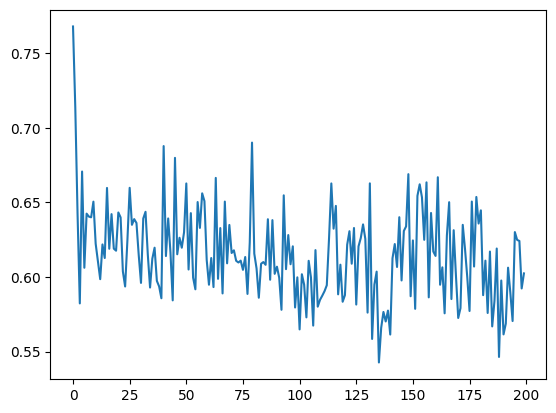

Train Accuracies


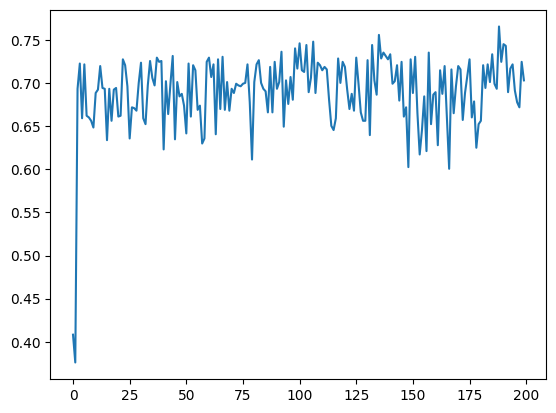

Validation Losses


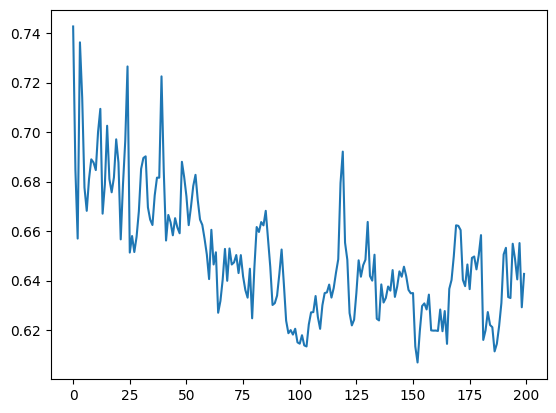

Validation Accuracies


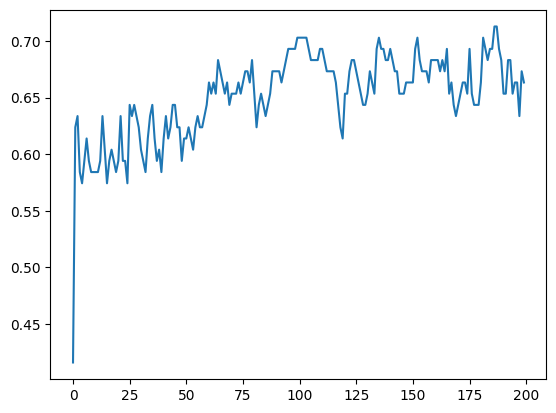

In [10]:
print("Train Losses")
plt.plot(train_losses)
plt.show()
print("Train Accuracies")
plt.plot(train_accuracies)
plt.show()
print("Validation Losses")
plt.plot(val_losses)
plt.show()
print("Validation Accuracies")
plt.plot(val_accuracies)
plt.show()

## Performance on the test set

In [11]:
seed_everything(77)
model.eval()
test_loss = 0.0
test_acc=0.0
for i, data in enumerate(tqdm(test_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        test_acc+=acc
        test_loss += loss.item()

epoch_test_loss=test_loss/len(test_loader) # Average test loss
epoch_test_accuracy=test_acc/len(test_loader) #Average test accuracy
print(f"Test loss epoch {epoch}: ", epoch_test_loss)
print(f"Test accuracy epoch {epoch}: ", epoch_test_accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.23it/s]

Test loss epoch 199:  0.6045722961425781
Test accuracy epoch 199:  0.7142857142857143


## Further Results

Removing the decoder apparently boosts performances.
We remind that to have a complete map of our tests, please look at _experiments.pdf_ in this repository.